
#Assignment Set 6

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



In [ ]:
#@title Manual Data Injection
from six.moves import cPickle as pickle
import platform
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
 
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar/cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
 
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
 
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
 
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
 
    x_train = X_train.astype('float32')
    x_val = X_val.astype('float32')
    x_test = X_test.astype('float32')
    
    std = StandardScaler()

    x_train = std.fit_transform(x_train)
    x_val = std.transform(x_val)
    x_test = std.transform(x_test)

    return x_train, y_train, x_val, y_val, x_test, y_test
 
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()
 
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [ ]:
#@title Single Hidden Layer NNs **Without** Output One-Hot Encoding
#@markdown by using sparse categorical cross entropy there is no need to one-hot encode the true lables and from_logits set to true thus the model doesnt have any normalization layer.
epochs =  20#@param {type:"integer"}
verbose =  0#@param {type:"number"}

mdl_pool = {}
 
name = 'clf_flatten'
input = keras.Input(shape=(3072,))
x = layers.Dense(512, activation="relu")(input)
x = layers.Dense(256, activation="relu")(x)
output = layers.Dense(10)(x)
nonregularized_model = keras.Model(inputs=input, outputs=output, name=name)
 
nonregularized_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer='Adam',
                metrics=['accuracy'])
mdl_pool[name] = {'params':nonregularized_model.count_params(),
                    'nolayers':2}
if(verbose):
    nonregularized_model.summary()
mdl_pool[name]['history'] = nonregularized_model.fit(x = x_train, y = y_train,
                    batch_size=64, epochs=epochs,
                    verbose=verbose,validation_data=(x_val,y_val),
                    validation_batch_size = 64).history

name = 'clf_flatten_regularized'
input = keras.Input(shape=(3072,))
x = layers.Dense(512, activation="relu",kernel_regularizer=regularizers.l2(1e-4))(input)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation="relu",kernel_regularizer=regularizers.l2(1e-4))(x)
output = layers.Dense(10)(x)
l2regularized_model = keras.Model(inputs=input, outputs=output, name=name)
 
l2regularized_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer='Adam',
                metrics=['accuracy'])
mdl_pool[name] = {'params':l2regularized_model.count_params(),
                    'nolayers':2}
if(verbose):
    l2regularized_model.summary()
mdl_pool[name]['history'] = l2regularized_model.fit(x = x_train, y = y_train,
                    batch_size=64, epochs=epochs,
                    verbose=verbose,validation_data=(x_val,y_val),
                    validation_batch_size = 64).history

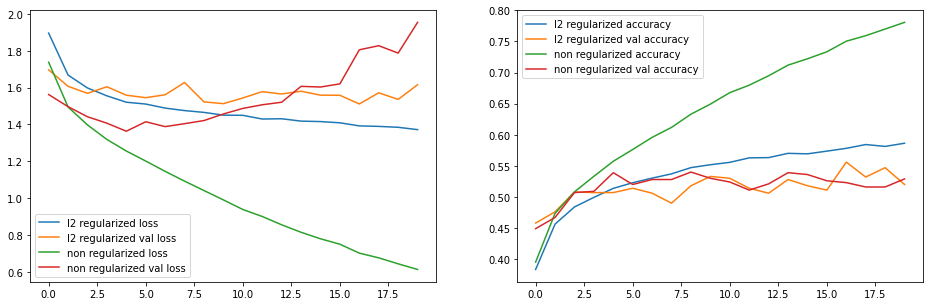

In [ ]:
#@title Plotting Training History
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(mdl_pool['clf_flatten_regularized']['history']['loss'],label = 'l2 regularized loss')
plt.plot(mdl_pool['clf_flatten_regularized']['history']['val_loss'],label = 'l2 regularized val loss')
plt.plot(mdl_pool['clf_flatten']['history']['loss'],label = 'non regularized loss')
plt.plot(mdl_pool['clf_flatten']['history']['val_loss'],label = 'non regularized val loss')
plt.legend()

plt.subplot(122)
plt.plot(mdl_pool['clf_flatten_regularized']['history']['accuracy'],label = 'l2 regularized accuracy')
plt.plot(mdl_pool['clf_flatten_regularized']['history']['val_accuracy'],label = 'l2 regularized val accuracy')
plt.plot(mdl_pool['clf_flatten']['history']['accuracy'],label = 'non regularized accuracy')
plt.plot(mdl_pool['clf_flatten']['history']['val_accuracy'],label = 'non regularized val accuracy')
plt.legend()

In [ ]:
#@title Evaluation of The L2 Regularized Model and Non Regularized Model
print(nonregularized_model.evaluate(x_test, y_test))
print(l2regularized_model.evaluate(x_test, y_test))

313/313 [==============================] - 1s 2ms/step - loss: 1.9367 - accuracy: 0.5192
[1.9367173910140991, 0.5192000269889832]
313/313 [==============================] - 1s 2ms/step - loss: 1.6053 - accuracy: 0.5171
[1.6052554845809937, 0.5170999765396118]


In [ ]:
x_train = x_train.reshape((-1,3,32,32))
x_train = np.transpose(x_train, (0,2, 3, 1))
x_train.shape

x_val = x_val.reshape((-1,3,32,32))
x_val = np.transpose(x_val, (0,2, 3, 1))
x_val.shape

x_test = x_test.reshape((-1,3,32,32))
x_test = np.transpose(x_test, (0,2, 3, 1))
x_test.shape

(10000, 32, 32, 3)

In [ ]:
#@title Multi Hidden Layer CNNs **Without** Output One-Hot Encoding
#@markdown Training a convolutional neural network to compare the performance
name = 'conv_clf'
 
input = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32,3,activation="relu")(input)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.Conv2D(32,3,activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32,3,activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128,activation="relu")(x)
output = layers.Dense(10,'softmax')(x)
nonregularized_model = keras.Model(inputs=input, outputs=output, name=name)
nonregularized_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
            optimizer='Adam',
            metrics=['accuracy'])

name = 'conv_clf_l2_regularized'
 
input = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32,3,activation="relu",kernel_regularizer=regularizers.l2(1e-4))(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(32,3,activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32,3,activation="relu",kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32,3,activation="relu",kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128,activation="relu",kernel_regularizer=regularizers.l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(10,'softmax')(x)
l2regularized_model = keras.Model(inputs=input, outputs=output, name=name)
l2regularized_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
            optimizer='Adam',
            metrics=['accuracy'])

In [ ]:
epochs =  100#@param {type:"integer"}
verbose =  0#@param {type:"number"}
nonregularized_model.fit(x = x_train, y = y_train,
                        batch_size=64, epochs=epochs,
                        verbose=verbose,validation_data=(x_val,y_val),
                        validation_batch_size = 64)
l2regularized_model.fit(x = x_train, y = y_train,
                        batch_size=64, epochs=epochs,
                        verbose=verbose,validation_data=(x_val,y_val),
                        validation_batch_size = 64)

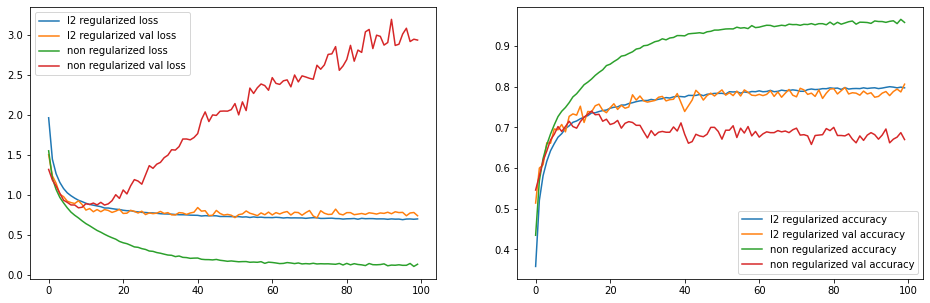

In [ ]:
#@title Plotting Training History
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(l2regularized_model.history.history['loss'],label = 'l2 regularized loss')
plt.plot(l2regularized_model.history.history['val_loss'],label = 'l2 regularized val loss')
plt.plot(nonregularized_model.history.history['loss'],label = 'non regularized loss')
plt.plot(nonregularized_model.history.history['val_loss'],label = 'non regularized val loss')
plt.legend()

plt.subplot(122)
plt.plot(l2regularized_model.history.history['accuracy'],label = 'l2 regularized accuracy')
plt.plot(l2regularized_model.history.history['val_accuracy'],label = 'l2 regularized val accuracy')
plt.plot(nonregularized_model.history.history['accuracy'],label = 'non regularized accuracy')
plt.plot(nonregularized_model.history.history['val_accuracy'],label = 'non regularized val accuracy')
plt.legend()

In [ ]:
#@title Evaluation of The L2 Regularized Model and Non Regularized Model
print(nonregularized_model.evaluate(x_test, y_test))
print(l2regularized_model.evaluate(x_test, y_test))

313/313 [==============================] - 1s 3ms/step - loss: 2.9974 - accuracy: 0.6795
[2.9973909854888916, 0.6794999837875366]
313/313 [==============================] - 1s 3ms/step - loss: 0.7554 - accuracy: 0.7829
[0.7554150819778442, 0.7828999757766724]
